In [1]:
import numpy as np
from matplotlib import pyplot as plt
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux, SchwarzEccFlux
from few.utils.utility import get_p_at_t
from few.utils.constants import MTSUN_SI, YRSID_SI
from numpy import pi
import os

from bhpwave.waveform import KerrWaveform
from  bhpwave.trajectory.inspiral import InspiralGenerator


import multiprocessing
num_threads = multiprocessing.cpu_count()
from  bhpwave.trajectory.inspiral import InspiralGenerator
traj_BHPWave = InspiralGenerator(trajectory_data=None)
# traj_l30_Has = EMRIInspiral(func="Relativistic_Kerr_Circ_Flux") # my flux and lmax = 30
traj_few = EMRIInspiral(func = SchwarzEccFlux, integrate_constants_of_motion=False) 
traj_Kerr_ecc = EMRIInspiral(func= KerrEccEqFlux, integrate_constants_of_motion=False) 

In [2]:
M = 1e6
mu = 1e1

MM = M+mu
mumu = M*mu/(M+mu)    # for tje new mass convention as input for the BHPWave

a = 0.0    # non-rotating case
dt = 1.0
dtz = 40.0 # this is to have less number of point for Zach's traj
T = 4.0
e0 = 0.0
Y0 = 1.0
x0 = 1.0
n_points_interp = 500

####### Loading the saved data from KerrCir version of FEW ---> https://github.com/Hassankh92/FastEMRIWaveforms_KerrCircNonvac
###### Download the data from :
#  https://perimeter-my.sharepoint.com/:f:/g/personal/hkhalvati_perimeterinstitute_ca/EpClG00fwZVNsch7WU2OrGQBdtY8cctLCEdKmemo2S7fZw?e=KbP3cX
path = os.getcwd() + '/'#"/home/hkhalvati/Downloads/KerrEccentricEquatorialFigures/scripts/Results/Cross_tests/"
traj_KerrCirc_result = np.loadtxt(path + "Traj_KerrCirc_full_newmass.txt")
mask_traj_has = traj_KerrCirc_result[:,0] == a
# ah, th, ph, eh, xh, Phi_phih, Phi_thetah, Phi_rh = traj_KerrCirc_result[mask_traj_has]
th =  traj_KerrCirc_result[mask_traj_has][:,1]
ph =  traj_KerrCirc_result[mask_traj_has][:,2]
Phi_phih = traj_KerrCirc_result[mask_traj_has][:,3]
p0 = ph[0]
print(f"p0:{p0} for a = {a}")

Zach_traj_resul = traj_BHPWave(MM, mumu, a, p0, dt=dtz, T=T, num_threads=num_threads)
Phi_phiZ = Zach_traj_resul.inspiral_data.phase
tZ = Zach_traj_resul.inspiral_data.time
pZ = Zach_traj_resul.inspiral_data.radius
# tz, pz, ez, xz, Phi_phiz, Phi_thetaz, Phi_rz = traj_l30_pybhpt(M,mu,a0,p0,e0,Y0,A0,nr0,T=T, dt=dt)



# -------- Notice that the trajectories are not in the coordinate time, so the t is t/M and to make it into sec we have to use t*M*MTSUN_SI--------------
result_kerr_ecc = traj_Kerr_ecc(M,mu,a,p0,e0,Y0,in_coordinate_time=False, dt=dt, T=T,max_init_len=int(1e5) ,err=1e-17)
Phi_phik = result_kerr_ecc[4]
tk = result_kerr_ecc[0]
pk = result_kerr_ecc[1]


### Schwarzchild case from the new style traj FEW
result_Fnew = traj_few(M,mu,a,p0,e0,Y0,in_coordinate_time=False, dt=dt, T=T,max_init_len=int(1e5),err=1e-17)
t_Fnew = result_Fnew[0]
p_Fnew = result_Fnew[1]
Phi_phi_Fnew = result_Fnew[4]




print("min separations a=0 case, ph, pz, pfew_new, p_kerr", ph[-1], pZ[-1], p_Fnew[-1], pk[-1])





from bhpwave.constants import Modot_GC1_to_S
Mt2st_BHPWave = (M*Modot_GC1_to_S)
Mt2st_FEW = M*MTSUN_SI

print("mass in second from Zach: ", Mt2st_BHPWave,'\n', "mass in second from FEW: ", Mt2st_FEW,'\n', "fracional error of the two", (Mt2st_BHPWave-Mt2st_FEW)/Mt2st_FEW)



splineh = CubicSplineInterpolant(th,Phi_phih )  # spline for Has's traj
spline_Fnew = CubicSplineInterpolant(t_Fnew, Phi_phi_Fnew) #  spline for FEW's traj frm new version 
splineZ = CubicSplineInterpolant(tZ, Phi_phiZ) # spline for Zach's traj
splinek = CubicSplineInterpolant(tk, Phi_phik) # spline for Kerr's traj



print("tfinal Has in years = ",th[-1]/YRSID_SI*Mt2st_FEW)
print("tfinal Zach in years = ",tZ[-1]*Mt2st_BHPWave/YRSID_SI)
print("tfinal FEW in years = ",t_Fnew[-1]/YRSID_SI*Mt2st_FEW)
print("tfinal Kerr in years = ",tk[-1]/YRSID_SI*Mt2st_FEW)

ini = 0
fin = min(th[-1], t_Fnew[-1], tZ[-1], tk[-1]) - 1e-6
t = np.linspace(ini,fin,n_points_interp)
Phi_phispl_l30h = splineh(t)
Phi_phispl_Fnew = spline_Fnew(t)
Phi_phispl_Z = splineZ(t)
Phi_phispl_k = splinek(t)

Phi_phispl_l30h = Phi_phispl_l30h.get()
Phi_phispl_Z = Phi_phispl_Z.get()
Phi_phispl_Fnew = Phi_phispl_Fnew.get()
Phi_phispl_k = Phi_phispl_k.get()


print(f"final phase for a=0,  Has phase:{Phi_phispl_l30h[-1]:.8f}, Fnew phase:{Phi_phispl_Fnew[-1]:.8f}, BHPWave phase:{Phi_phispl_Z[-1]:.8f}, Kerr phase:{Phi_phispl_k[-1]:.8f}")

t_plot = t/YRSID_SI*Mt2st_FEW

δϕH_Fnew = (Phi_phispl_l30h - Phi_phispl_Fnew)
δϕh_k = (Phi_phispl_l30h - Phi_phispl_k) #flux from my solver and Kerr's traj


δϕz_Fnew = (Phi_phispl_Fnew - Phi_phispl_Z)
δϕz_k = (Phi_phispl_k - Phi_phispl_Z)


δϕh_z = (Phi_phispl_l30h - Phi_phispl_Z) #flux from my solver and Zach's pybhpt both l30

print(f"final delta phi for H_Fnew:{δϕH_Fnew[-1]}, H_BHPWave:{δϕh_z[-1]}, Fnew_BHPWave:{δϕz_Fnew[-1]}, H_Kerr:{δϕh_k[-1]}")



# For rotating case: 
a2 = 0.99
##### loading saved data form the old FEW Kerr circular version
# traj_KerrCirc_result = np.loadtxt(path+"Traj_KerrCirc_full_newmass.txt")
mask_traj_has = traj_KerrCirc_result[:,0] == a2
th =  traj_KerrCirc_result[mask_traj_has][:,1]
ph =  traj_KerrCirc_result[mask_traj_has][:,2]
Phi_phih = traj_KerrCirc_result[mask_traj_has][:,3]
p0 = ph[0]
print(f"p0:{p0} for a = {a2}")

Zach_traj_resul = traj_BHPWave(MM, mumu, a2, p0, dt=dtz, T=T, num_threads=num_threads)
Phi_phiZ = Zach_traj_resul.inspiral_data.phase
tZ = Zach_traj_resul.inspiral_data.time
pZ = Zach_traj_resul.inspiral_data.radius


result_kerr_ecc = traj_Kerr_ecc(M,mu,a2,p0,e0,Y0,in_coordinate_time=False, dt=dt, T=T,max_init_len=int(1e5) ,err=1e-17)
Phi_phik = result_kerr_ecc[4]
tk = result_kerr_ecc[0]
pk = result_kerr_ecc[1]

print(f"min separations a=0.99 case: KerrCirc {ph[-1]}, KerrEcc {pk[-1]}, BHPWave {pZ[-1]}")

splineh2 = CubicSplineInterpolant(th, Phi_phih)
splineZ2 = CubicSplineInterpolant(tZ, Phi_phiZ)
splinek2 = CubicSplineInterpolant(tk, Phi_phik)

ini = 0
fin = min(th[-1], tZ[-1], tk[-1]) 
t = np.linspace(ini,fin,n_points_interp)
Phi_phispl_l30h = splineh2(t)
Phi_phispl_Z = splineZ2(t)
Phi_phispl_k = splinek2(t)

Phi_phispl_l30h = Phi_phispl_l30h.get()
Phi_phispl_Z = Phi_phispl_Z.get()
Phi_phispl_k = Phi_phispl_k.get()


t_plot2 = t/YRSID_SI*Mt2st_FEW
δϕh_z99 = (Phi_phispl_l30h - Phi_phispl_Z) #flux from my solver and Zach's pybhpt both l30
δϕh_k99 = (Phi_phispl_l30h - Phi_phispl_k) #flux from my solver and Kerr's traj
δϕz_k99 = (Phi_phispl_k - Phi_phispl_Z)

print(f"final delta phi for H_BHPWave:{δϕh_z99[-1]}, H_Kerr:{δϕh_k99[-1]}")
print(f"final phases for a=0.99,  KerrCirc phase:{Phi_phispl_l30h[-1]:.8f}, KerrEcc phase:{Phi_phispl_k[-1]:.8f} BHPWave phase:{Phi_phispl_Z[-1]:.8f}")



# For rotating case: 
a2 = -0.99
##### loading saved data form the old FEW Kerr circular version
# traj_KerrCirc_result = np.loadtxt(path+"Traj_KerrCirc_full_newmass.txt")
mask_traj_has = traj_KerrCirc_result[:,0] == a2
th =  traj_KerrCirc_result[mask_traj_has][:,1]
ph =  traj_KerrCirc_result[mask_traj_has][:,2]
Phi_phih = traj_KerrCirc_result[mask_traj_has][:,3]
p0 = ph[0]
print(f"p0:{p0} for a = {a2}")

Zach_traj_resul = traj_BHPWave(MM, mumu, a2, p0, dt=dtz, T=T, num_threads=num_threads)
Phi_phiZ = Zach_traj_resul.inspiral_data.phase
tZ = Zach_traj_resul.inspiral_data.time
pZ = Zach_traj_resul.inspiral_data.radius


result_kerr_ecc = traj_Kerr_ecc(M,mu,a2,p0,e0,Y0,in_coordinate_time=False, dt=dt, T=T,max_init_len=int(1e5) ,err=1e-17)
Phi_phik = result_kerr_ecc[4]
tk = result_kerr_ecc[0]
pk = result_kerr_ecc[1]

print(f"min separations a=0.99 case: KerrCirc {ph[-1]}, KerrEcc {pk[-1]}, BHPWave {pZ[-1]}")

splineh2 = CubicSplineInterpolant(th, Phi_phih)
splineZ2 = CubicSplineInterpolant(tZ, Phi_phiZ)
splinek2 = CubicSplineInterpolant(tk, Phi_phik)

ini = 0
fin = min(th[-1], tZ[-1], tk[-1]) 
t = np.linspace(ini,fin,n_points_interp)
Phi_phispl_l30h = splineh2(t)
Phi_phispl_Z = splineZ2(t)
Phi_phispl_k = splinek2(t)

Phi_phispl_l30h = Phi_phispl_l30h.get()
Phi_phispl_Z = Phi_phispl_Z.get()
Phi_phispl_k = Phi_phispl_k.get()


t_plot2_retro = t/YRSID_SI*Mt2st_FEW
δϕh_z99_retro = (Phi_phispl_l30h - Phi_phispl_Z) #flux from my solver and Zach's pybhpt both l30
δϕh_k99_retro = (Phi_phispl_l30h - Phi_phispl_k) #flux from my solver and Kerr's traj
δϕz_k99_retro = (Phi_phispl_k - Phi_phispl_Z)

print(f"final delta phi for H_BHPWave:{δϕh_z99_retro[-1]}, H_Kerr:{δϕh_k99_retro[-1]}")
print(f"final phases for a=0.99,  KerrCirc phase:{Phi_phispl_l30h[-1]:.8f}, KerrEcc phase:{Phi_phispl_k[-1]:.8f} BHPWave phase:{Phi_phispl_Z[-1]:.8f}")








p0:12.0318251349591 for a = 0.0
min separations a=0 case, ph, pz, pfew_new, p_kerr 6.10000000820182 6.100072230164793 6.100023829751672 6.099960495395164
mass in second from Zach:  4.925490949173312 
 mass in second from FEW:  4.9254909491978065 
 fracional error of the two -4.97294274035349e-12
tfinal Has in years =  3.9999595897865747
tfinal Zach in years =  3.99995876288157
tfinal FEW in years =  3.9999600003999958
tfinal Kerr in years =  3.9999600003999958
final phase for a=0,  Has phase:802696.79951513, Fnew phase:802696.71153492, BHPWave phase:802696.80387113, Kerr phase:802696.80407369
final delta phi for H_Fnew:0.08798021194525063, H_BHPWave:-0.004356004879809916, Fnew_BHPWave:-0.09233621682506055, H_Kerr:-0.004558560322038829
p0:10.0314102904767 for a = 0.99
min separations a=0.99 case: KerrCirc 1.55449794761067, KerrEcc 1.5544690613608858, BHPWave 1.5545571620385787
final delta phi for H_BHPWave:-0.03608799213543534, H_Kerr:-0.05441917711868882
final phases for a=0.99,  KerrC

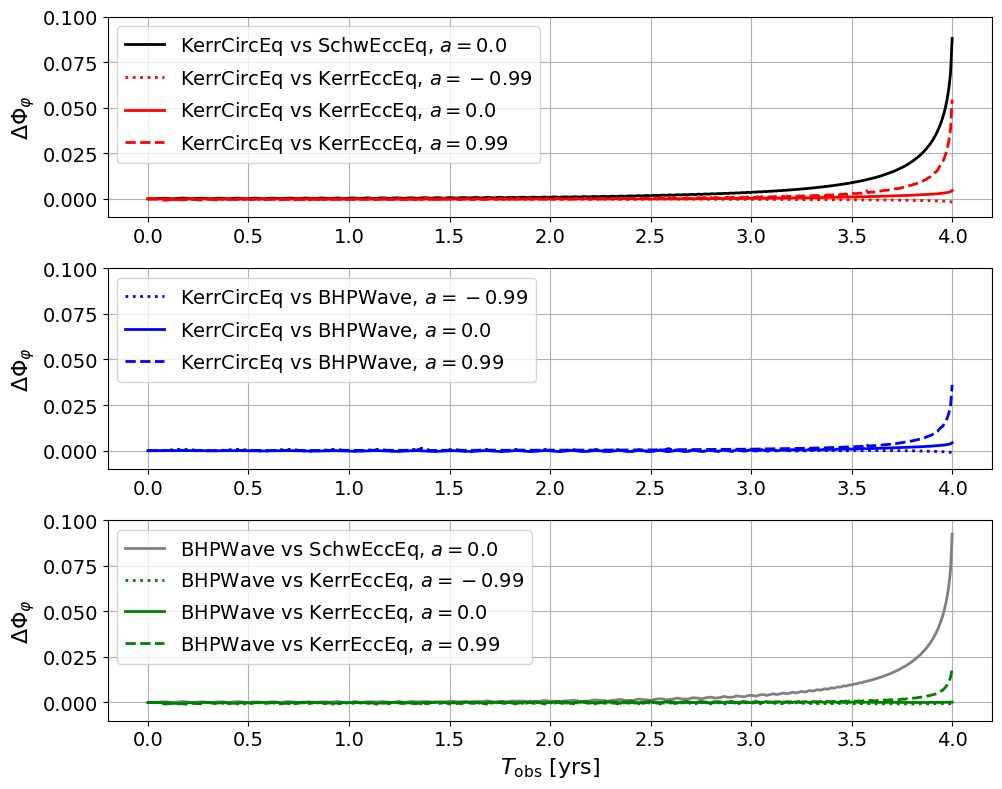

In [3]:
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14
thickness = 2

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax1.plot(t_plot, δϕH_Fnew , '-k', label='KerrCircEq vs SchwEccEq, $a = 0.0$', linewidth=thickness, rasterized=True)
ax1.plot(t_plot2_retro, -δϕh_k99_retro , ':r', label='KerrCircEq vs KerrEccEq, $a = -0.99$', linewidth=thickness, rasterized=True)
ax1.plot(t_plot, -δϕh_k , '-r', label='KerrCircEq vs KerrEccEq, $a = 0.0$', linewidth=thickness, rasterized=True)
ax1.plot(t_plot2, -δϕh_k99 , '--r', label='KerrCircEq vs KerrEccEq, $a = 0.99$', linewidth=thickness, rasterized=True)
ax1.grid()
ax1.set_ylabel(r'$\Delta \Phi_{\varphi}$', fontsize=label_fontsize)
# ax1.set_xlabel(r'$T_{\rm obs}$ [yrs]', fontsize=label_fontsize)
ax1.legend(fontsize=legend_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax1.set_ylim(-0.01, 0.1)

ax2.plot(t_plot2_retro, -δϕh_z99_retro , ':b', label='KerrCircEq vs BHPWave, $a = -0.99$', linewidth=thickness, rasterized=True)
ax2.plot(t_plot, -δϕh_z , '-b', label='KerrCircEq vs BHPWave, $a = 0.0$', linewidth=thickness, rasterized=True)
ax2.plot(t_plot2, -δϕh_z99 , '--b', label='KerrCircEq vs BHPWave, $a = 0.99$', linewidth=thickness, rasterized=True)
ax2.grid()
ax2.set_ylabel(r'$\Delta \Phi_{\varphi}$', fontsize=label_fontsize)
# ax2.set_xlabel(r'$T_{\rm obs}$ [yrs]', fontsize=label_fontsize)
ax2.legend(fontsize=legend_fontsize, loc='upper left')
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax2.set_ylim(-0.01, 0.1)


ax3.plot(t_plot, -δϕz_Fnew , '-',color="grey", label='BHPWave vs SchwEccEq, $a = 0.0$', linewidth=thickness, rasterized=True)
ax3.plot(t_plot2_retro, δϕz_k99_retro , ':g', label='BHPWave vs KerrEccEq, $a = -0.99$', linewidth=thickness, rasterized=True)
ax3.plot(t_plot2, δϕz_k , '-g', label='BHPWave vs KerrEccEq, $a = 0.0$', linewidth=thickness, rasterized=True)
ax3.plot(t_plot2, δϕz_k99 , '--g', label='BHPWave vs KerrEccEq, $a = 0.99$', linewidth=thickness, rasterized=True)
ax3.grid()
ax3.set_ylabel(r'$\Delta \Phi_{\varphi}$', fontsize=label_fontsize)
ax3.set_xlabel(r'$T_{\rm obs}$ [yrs]', fontsize=label_fontsize)
ax3.legend(fontsize=legend_fontsize)
ax3.tick_params(axis='both', which='major', labelsize=tick_fontsize)
ax3.set_ylim(-0.01, 0.1)

plt.tight_layout()
# plt.savefig('Cross_codes_phase_shift.pdf')
